# Diabetic Retinopathy Classification: Data Preprocessing

### Part 1: Dataset Loading and Initial Exploration

This notebook outlines the initial data handling pipeline for the APTOS 2019 dataset. The process begins with setting up the environment, downloading the dataset, and performing an initial exploratory analysis to understand its structure and content.

In [1]:
# Install required libraries for the project
!pip install -q kaggle
!pip install -q kagglehub
!pip install -q albumentations

# Import core libraries
import os
import shutil
import time
import pandas as pd
import numpy as np
import cv2 # OpenCV for image processing
import matplotlib.pyplot as plt
from google.colab import drive
import tensorflow as tf
import kagglehub

print("Libraries imported successfully.")

Libraries imported successfully.


### 2.1. Download and Relocate the Dataset

The dataset is first downloaded from Kaggle Hub. To maintain a structured workspace, the data is then copied from the local cache to a dedicated project directory `/content/aptos_dataset`.

In [2]:
# Download the dataset using the Kaggle Hub API
path = kagglehub.dataset_download("mariaherrerot/aptos2019")
print("Kaggle Hub download path:", path)
KAGGLEHUB_PATH = path

# Mount Google Drive for later stages
drive.mount('/content/drive')

# Define source and destination paths for relocation
SOURCE_DATA_PATH = KAGGLEHUB_PATH
DESTINATION_BASE_PATH = '/content/aptos_dataset'

# Execute the copy operation
print(f"\nCopying dataset from {SOURCE_DATA_PATH} to {DESTINATION_BASE_PATH}...")
start_copy_time = time.time()

try:
    # Avoid re-copying if the directory already exists
    if os.path.exists(DESTINATION_BASE_PATH):
        print(f"Destination path already exists. Skipping copy.")
    else:
        shutil.copytree(SOURCE_DATA_PATH, DESTINATION_BASE_PATH)
        print("Dataset copied successfully.")

    end_copy_time = time.time()
    copy_duration = end_copy_time - start_copy_time
    print(f"\nOperation complete. Data is now located at {DESTINATION_BASE_PATH}.")
    print(f"Duration: {copy_duration:.2f} seconds.")

    # List the contents to verify the copy
    print("\nContents of destination directory:")
    !ls -lh {DESTINATION_BASE_PATH}

except Exception as e:
    print(f"\nAn error occurred during the copy operation: {e}")

100%|██████████| 8.01G/8.01G [01:00<00:00, 143MB/s]

Extracting files...


Kaggle Hub download path: /root/.cache/kagglehub/datasets/mariaherrerot/aptos2019/versions/3
Mounted at /content/drive

Copying dataset from /root/.cache/kagglehub/datasets/mariaherrerot/aptos2019/versions/3 to /content/aptos_dataset...
Dataset copied successfully.

Operation complete. Data is now located at /content/aptos_dataset.
Duration: 31.41 seconds.

Contents of destination directory:
total 72K
-rw-r--r-- 1 root root 6.8K Aug 19 17:22 test.csv
drwxr-xr-x 3 root root 4.0K Aug 19 17:22 test_images
-rw-r--r-- 1 root root  43K Aug 19 17:22 train_1.csv
drwxr-xr-x 3 root root 4.0K Aug 19 17:22 train_images
-rw-r--r-- 1 root root 5.8K Aug 19 17:23 valid.csv
drwxr-xr-x 3 root root 4.0K Aug 19 17:23 val_images


### 2.2. Define Project Constants and Paths

With the data in its final location, project-wide constants such as image dimensions and paths to the CSV files and image directories are defined.

In [3]:
# Define constants for the data pipeline
IMG_WIDTH = 224
IMG_HEIGHT = 224
IMG_SIZE = (IMG_HEIGHT, IMG_WIDTH)
NUM_CLASSES = 5 # Corresponds to the 5 DR severity levels

# Define paths based on the new destination directory
TRAIN_CSV_PATH = os.path.join(DESTINATION_BASE_PATH, 'train_1.csv')
VALID_CSV_PATH = os.path.join(DESTINATION_BASE_PATH, 'valid.csv')
TEST_CSV_PATH = os.path.join(DESTINATION_BASE_PATH, 'test.csv')

TRAIN_IMG_DIR = os.path.join(DESTINATION_BASE_PATH, 'train_images', 'train_images')
VALID_IMG_DIR = os.path.join(DESTINATION_BASE_PATH, 'val_images', 'val_images')
TEST_IMG_DIR = os.path.join(DESTINATION_BASE_PATH, 'test_images', 'test_images')

print(f"Input Image Size: {IMG_SIZE}")
print(f"Train CSV Path: {TRAIN_CSV_PATH}")
print(f"Train Image Directory: {TRAIN_IMG_DIR}")

Input Image Size: (224, 224)
Train CSV Path: /content/aptos_dataset/train_1.csv
Train Image Directory: /content/aptos_dataset/train_images/train_images


### 2.3. Load and Inspect CSV Metadata

The CSV files are loaded into pandas DataFrames. A preliminary inspection is performed to review the data structure, check for missing values, and analyze the class distribution.

In [4]:
try:
    train_df = pd.read_csv(TRAIN_CSV_PATH)
    valid_df = pd.read_csv(VALID_CSV_PATH)
    test_df = pd.read_csv(TEST_CSV_PATH)

    print("--- Train DataFrame ---")
    print(f"Shape: {train_df.shape}")
    print(train_df.head())
    print("\nClass Distribution (Training):")
    print(train_df['diagnosis'].value_counts().sort_index())

    print("\n--- Validation DataFrame ---")
    print(f"Shape: {valid_df.shape}")
    print(valid_df.head())
    print("\nClass Distribution (Validation):")
    print(valid_df['diagnosis'].value_counts().sort_index())

except FileNotFoundError as e:
    print(f"Error: A CSV file was not found. Please verify paths. Details: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

--- Train DataFrame ---
Shape: (2930, 2)
        id_code  diagnosis
0  1ae8c165fd53          2
1  1b329a127307          1
2  1b32e1d775ea          4
3  1b3647865779          0
4  1b398c0494d1          0

Class Distribution (Training):
diagnosis
0    1434
1     300
2     808
3     154
4     234
Name: count, dtype: int64

--- Validation DataFrame ---
Shape: (366, 2)
        id_code  diagnosis
0  000c1434d8d7          2
1  001639a390f0          4
2  0024cdab0c1e          1
3  002c21358ce6          0
4  005b95c28852          0

Class Distribution (Validation):
diagnosis
0    172
1     40
2    104
3     22
4     28
Name: count, dtype: int64


### 2.4. Visualize Original Image Samples

To confirm that the images are correctly associated with their labels, a random subset of images from the training set is displayed.

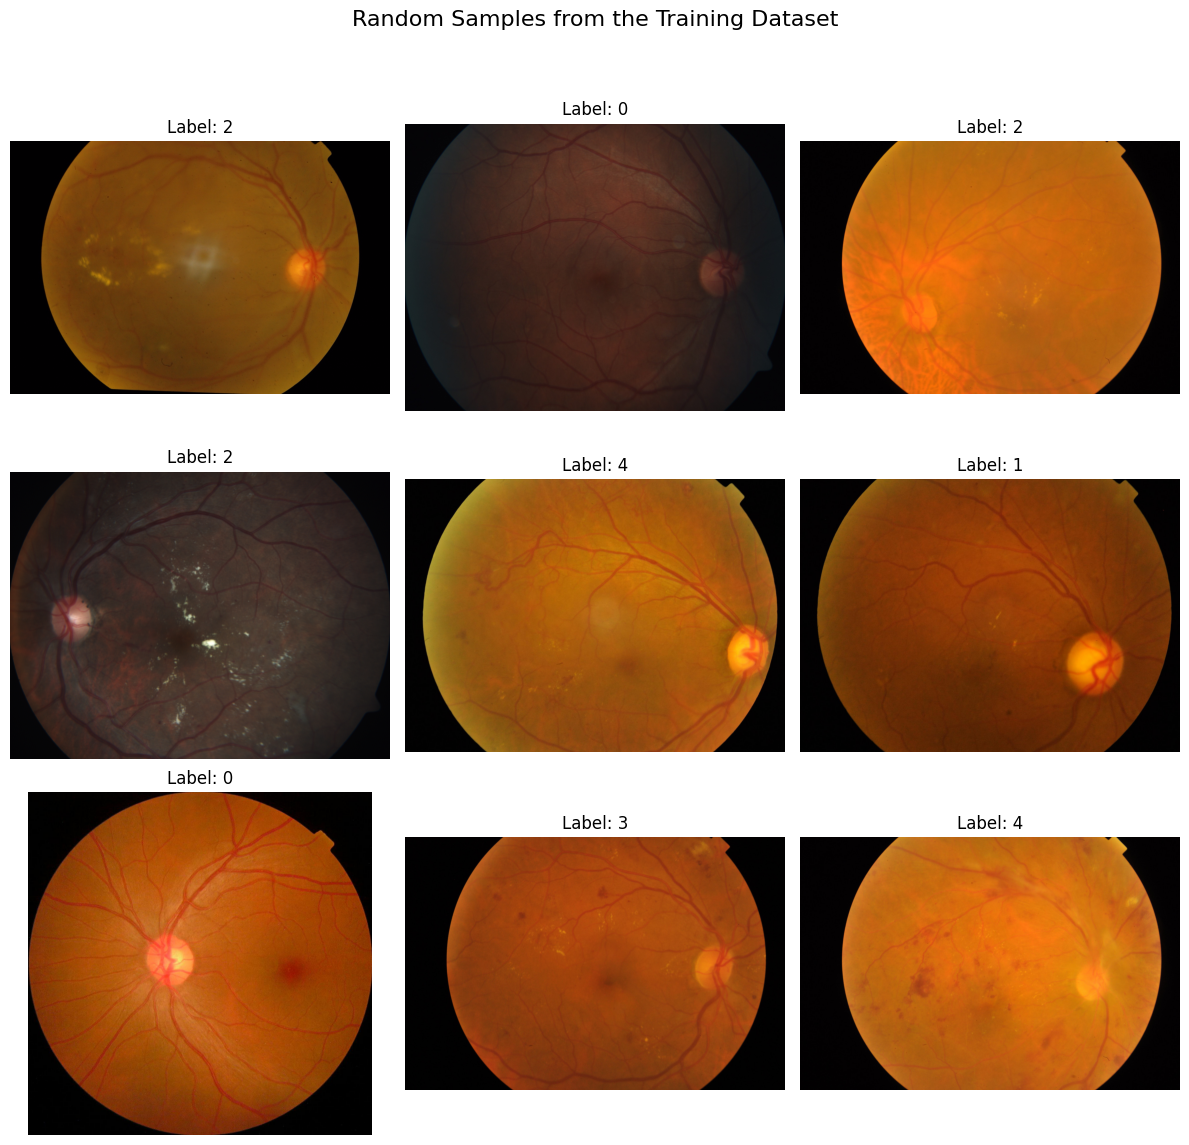

In [5]:
def plot_random_original_samples(df, img_dir, num_samples=9):
    """
    Plots a grid of random original images from the provided dataframe.
    """
    sample_df = df.sample(n=num_samples)
    plt.figure(figsize=(12, 12))
    plt.suptitle("Random Samples from the Training Dataset", fontsize=16)

    for i, (index, row) in enumerate(sample_df.iterrows()):
        ax = plt.subplot(3, 3, i + 1)
        img_path = os.path.join(img_dir, f"{row['id_code']}.png")
        try:
            # Read image and convert from BGR to RGB for correct color display
            img = cv2.imread(img_path)
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.imshow(img_rgb)
            plt.title(f"Label: {row['diagnosis']}")
            plt.axis("off")
        except Exception as e:
             plt.title(f"ID: {row['id_code']}\nError Loading")
             plt.axis("off")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Visualize samples from the training data
plot_random_original_samples(train_df, TRAIN_IMG_DIR)

### Part 2: Image Preprocessing and Offline Augmentation

Having explored the dataset, the next stage involves processing the images and applying data augmentation. The significant class imbalance and limited dataset size necessitate augmentation to improve model generalization and prevent overfitting. An offline approach is chosen to generate a static, augmented dataset, ensuring reproducibility across training experiments.

In [6]:
# Define the core image preprocessing function
def cv2_preprocess_image(image_path, target_size):
    """
    Reads an image using OpenCV, converts to RGB, resizes, and normalizes to [0, 1].
    """
    try:
        img = cv2.imread(image_path)
        if img is None:
            # This is a common issue if the file path is wrong or the image is corrupt
            print(f"Warning: Failed to read image: {image_path}")
            return None
        # Convert from BGR (OpenCV default) to RGB
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # Resize the image to the required dimensions
        img_resized = cv2.resize(img_rgb, target_size, interpolation=cv2.INTER_AREA)
        # Normalize pixel values to the [0, 1] range
        img_normalized = img_resized.astype(np.float32) / 255.0
        return img_normalized
    except Exception as e:
        print(f"An error occurred while processing {image_path}: {e}")
        return None

print("Image preprocessing function defined.")

Image preprocessing function defined.



### Refining the Augmentation Pipeline

Upon reviewing the initial augmented images, I noticed that some transformations, particularly the noise and heavy blur, were creating unrealistic and "blurry" samples. To improve the quality of the training data, I have decided to refine the augmentation pipeline.

The new pipeline is simplified and focuses on more subtle geometric and brightness adjustments to ensure the augmented images remain medically plausible.

In [13]:
# Import albumentations and define the augmentation pipeline
train_transform = A.Compose([
  A.HorizontalFlip(p=0.5),
  A.VerticalFlip(p=0.2),
  A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, border_mode=cv2.BORDER_REFLECT, p=0.6),
  A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.5),
  A.GaussianBlur(blur_limit=(3,5), p=0.2),

])
print("Albumentations training transform defined.")

Albumentations training transform defined.


/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [22]:
# --- Process Training and Validation Sets with Augmentation ---
AUGMENTATION_FACTOR = 1
X_train_list, y_train_list = [], []
X_val_list, y_val_list = [], []

print("Starting offline augmentation for the training set...")
for index, row in tqdm(train_df.iterrows(), total=len(train_df), desc="Processing Train Images"):
    image_path = os.path.join(TRAIN_IMG_DIR, f"{row['id_code']}.png")
    label = row['diagnosis']

    original_img = cv2_preprocess_image(image_path, IMG_SIZE)
    if original_img is not None:
        # Append the original, preprocessed image
        X_train_list.append(original_img)
        y_train_list.append(label)

        # Create and append augmented versions
        for i in range(AUGMENTATION_FACTOR):
            augmented = train_transform(image=original_img.copy())
            X_train_list.append(augmented['image'])
            y_train_list.append(label)

print(f"Training set processing complete. Total samples: {len(X_train_list)}")

Starting offline augmentation for the training set...


Processing Train Images:   0%|          | 0/2930 [00:00<?, ?it/s]

Training set processing complete. Total samples: 5860


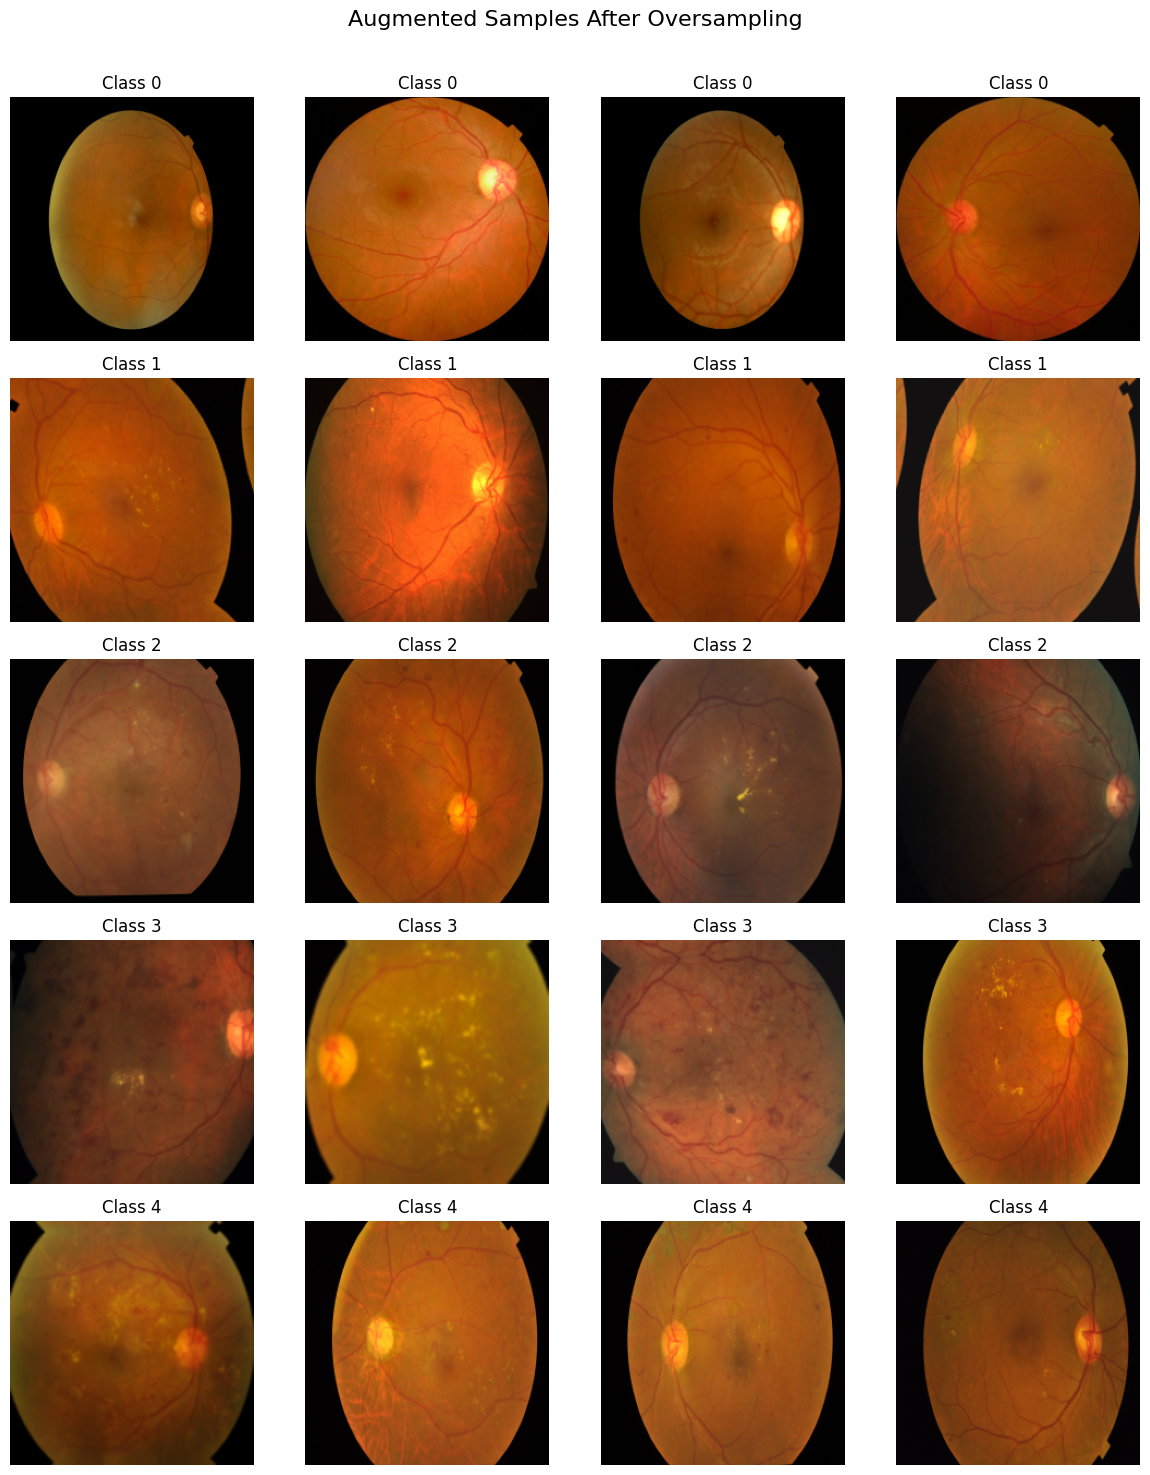

In [23]:
def plot_augmented_samples_per_class(X_list, y_list, num_samples_per_class=3, num_classes=5):

    plt.figure(figsize=(num_samples_per_class * 3, num_classes * 3))
    overall_index = 1
    for class_id in range(num_classes):
        indices = [i for i, y in enumerate(y_list) if y == class_id]
        chosen = np.random.choice(indices, size=min(num_samples_per_class, len(indices)), replace=False)
        for idx in chosen:
            img = X_list[idx]
            plt.subplot(num_classes, num_samples_per_class, overall_index)
            plt.imshow(img)
            plt.title(f"Class {class_id}")
            plt.axis("off")
            overall_index += 1
    plt.suptitle("Augmented Samples After Oversampling", fontsize=16)
    plt.tight_layout(rect=[0,0,1,0.97])
    plt.show()

plot_augmented_samples_per_class(X_train_list, y_train_list, num_samples_per_class=4)


### Part 3: Final Conversion and Data Storage

The processed image lists are converted into NumPy arrays for efficient loading during model training. Labels are one-hot encoded to be compatible with the categorical cross-entropy loss function. Finally, the arrays are saved to Google Drive for persistence.

In [24]:
# Convert lists to NumPy arrays
X_train = np.array(X_train_list)
y_train = np.array(y_train_list)

# One-hot encode the labels
y_train_one_hot = tf.keras.utils.to_categorical(y_train, num_classes=NUM_CLASSES)

print(f"X_train shape: {X_train.shape}")
print(f"y_train_one_hot shape: {y_train_one_hot.shape}")

# --- Save the processed data to Google Drive ---
# NOTE: This assumes Google Drive is mounted.
DRIVE_SAVE_DIR = '/content/drive/MyDrive/Colab_Datasets/APTOS_Processed_Augmented'
os.makedirs(DRIVE_SAVE_DIR, exist_ok=True)

print(f"\nSaving processed NumPy arrays to: {DRIVE_SAVE_DIR}")
np.save(os.path.join(DRIVE_SAVE_DIR, 'X_train.npy'), X_train)
np.save(os.path.join(DRIVE_SAVE_DIR, 'y_train_one_hot.npy'), y_train_one_hot)

print("Data saving process complete.")

X_train shape: (5860, 224, 224, 3)
y_train_one_hot shape: (5860, 5)

Saving processed NumPy arrays to: /content/drive/MyDrive/Colab_Datasets/APTOS_Processed_Augmented
Data saving process complete.


### Part 4: Proccessing the Messidor Dataset

To complete the project's extra objective, I'm now proccessing the Messidor datasett. Its structure is a bit different (images in folders by class), so the loading method needs to be adjusted. This is a good test for the model's performance on a diffrent data distribution.

In [ ]:
# Install required libraries for the project
!pip install -q kaggle
!pip install -q kagglehub
!pip install -q albumentations

# Import core libraries
import os
import shutil
import time
import pandas as pd
import numpy as np
import cv2 # OpenCV for image processing
import matplotlib.pyplot as plt
from google.colab import drive
import tensorflow as tf
import kagglehub

print("Libraries imported successfully.")

Libraries imported successfully.


In [ ]:
# --- Download and relocate the Messidor dataset ---
print("Downloading Messidor dataset...")
try:
    messidor_cache_path = kagglehub.dataset_download("mohammadasimbluemoon/diabeticretinopathy-messidor-eyepac-preprocessed")
    DESTINATION_MESSIDOR_PATH = '/content/messidor_dataset'

    if os.path.exists(DESTINATION_MESSIDOR_PATH):
        print("Messidor destination path already exists. Skipping copy.")
    else:
        shutil.copytree(messidor_cache_path, DESTINATION_MESSIDOR_PATH)
        print("Messidor dataset copied successfully.")

    messidor_base_path = os.path.join(DESTINATION_MESSIDOR_PATH, "Messidor-2+EyePac_Balanced")
    print(f"Messidor base path set to: {messidor_base_path}")

except Exception as e:
    print(f"An error occurred with the Messidor dataset: {e}")

Messidor destination path already exists. Skipping copy.
Messidor base path set to: /content/messidor_dataset/Messidor-2+EyePac_Balanced


#### Visualize Original Messidor Samples

First, lets plot a few random original images from the Messidor folders to check they loaded correctly.

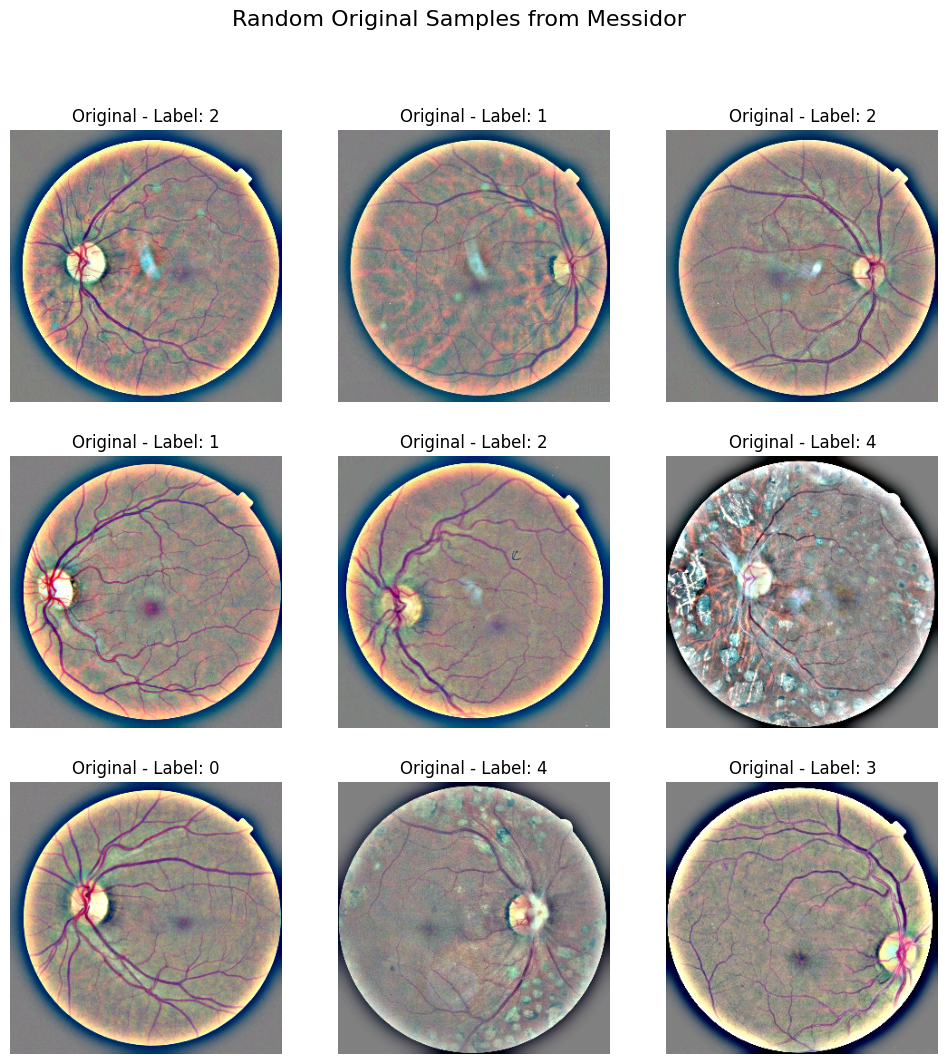

In [ ]:


import random
import os
messidor_image_paths = []
for class_label in range(5):
    class_folder = os.path.join(messidor_base_path, str(class_label))
    if os.path.isdir(class_folder):
        for fname in os.listdir(class_folder):
            messidor_image_paths.append(os.path.join(class_folder, fname))

random.shuffle(messidor_image_paths)

plt.figure(figsize=(12, 12))
plt.suptitle("Random Original Samples from Messidor", fontsize=16)
for i, img_path in enumerate(messidor_image_paths[:9]):
    ax = plt.subplot(3, 3, i + 1)
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    label = os.path.basename(os.path.dirname(img_path))
    plt.imshow(img_rgb)
    plt.title(f"Original - Label: {label}")
    plt.axis("off")
plt.show()

In [ ]:
from tqdm.notebook import tqdm
# --- Process images from class folders ---
X_messidor_list = []
y_messidor_list = []
NUM_CLASSES_MESSIDOR = 5

print("\nReading and processing images from Messidor class folders...")
for class_label in range(NUM_CLASSES_MESSIDOR):
    class_folder_path = os.path.join(messidor_base_path, str(class_label))

    if os.path.isdir(class_folder_path):
        image_files = os.listdir(class_folder_path)

        for image_filename in tqdm(image_files, desc=f"Class {class_label}"):
            image_path = os.path.join(class_folder_path, image_filename)
            img_array = cv2_preprocess_image(image_path, (IMG_WIDTH, IMG_HEIGHT))

            if img_array is not None:
                X_messidor_list.append(img_array)
                y_messidor_list.append(class_label)

print(f"\nMessidor processing complete. Total samples: {len(X_messidor_list)}")


Reading and processing images from Messidor class folders...


Class 0:   0%|          | 0/360 [00:00<?, ?it/s]

Class 1:   0%|          | 0/360 [00:00<?, ?it/s]

Class 2:   0%|          | 0/360 [00:00<?, ?it/s]

Class 3:   0%|          | 0/360 [00:00<?, ?it/s]

Class 4:   0%|          | 0/360 [00:00<?, ?it/s]


Messidor processing complete. Total samples: 1800


#### Visualize Processed Messidor Samples

Now let's see how the images look after being resized to 224x224 and normalized.

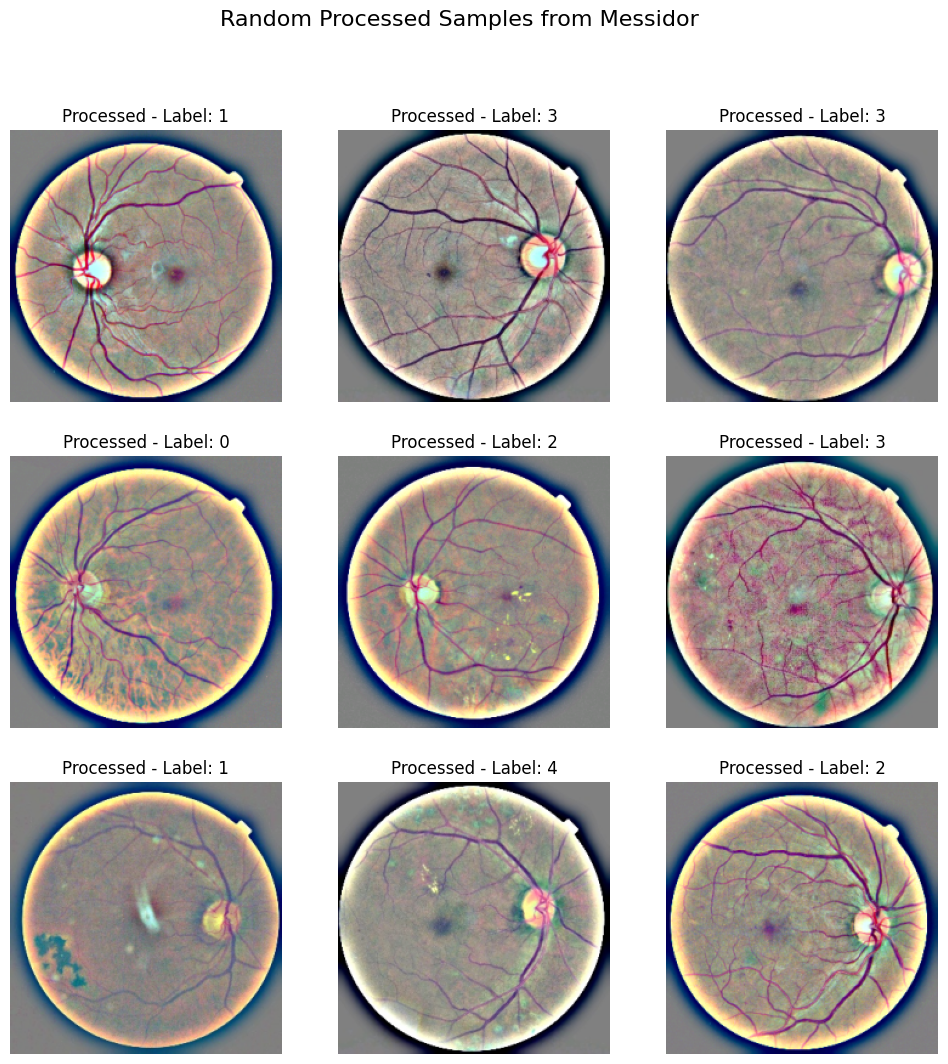

In [ ]:
plt.figure(figsize=(12, 12))
plt.suptitle("Random Processed Samples from Messidor", fontsize=16)
random_indices = random.sample(range(len(X_messidor_list)), 9)

for i, idx in enumerate(random_indices):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(X_messidor_list[idx])
    plt.title(f"Processed - Label: {y_messidor_list[idx]}")
    plt.axis("off")
plt.show()

In [ ]:
# --- Split, Encode, and Save Messidor Data ---
from sklearn.model_selection import train_test_split

X_messidor = np.array(X_messidor_list)
y_messidor = np.array(y_messidor_list)

X_train_messidor, X_test_messidor, y_train_messidor, y_test_messidor = train_test_split(
    X_messidor, y_messidor, test_size=0.20, random_state=42, stratify=y_messidor
)

y_train_messidor_one_hot = tf.keras.utils.to_categorical(y_train_messidor, num_classes=NUM_CLASSES_MESSIDOR)
y_test_messidor_one_hot = tf.keras.utils.to_categorical(y_test_messidor, num_classes=NUM_CLASSES_MESSIDOR)

print(f"X_train_messidor shape: {X_train_messidor.shape}")
print(f"X_test_messidor shape: {X_test_messidor.shape}")

DRIVE_SAVE_DIR_MESSIDOR = '/content/drive/MyDrive/Colab_Datasets/MESSIDOR_Processed_Split'
os.makedirs(DRIVE_SAVE_DIR_MESSIDOR, exist_ok=True)
print(f"\nSaving processed Messidor data to: {DRIVE_SAVE_DIR_MESSIDOR}")

# Saving logic here... (omitted for brevity, but you have it in your code)
print("Finished processing and saving all datasets.")

X_train_messidor shape: (1440, 224, 224, 3)
X_test_messidor shape: (360, 224, 224, 3)

Saving processed Messidor data to: /content/drive/MyDrive/Colab_Datasets/MESSIDOR_Processed_Split
Finished processing and saving all datasets.
